# RNAseq analysis workflow using DESeq2

In [3]:
library("DESeq2")
library(scales)
options(repr.plot.width=8, repr.plot.height=8)

Ensure we're in the correct directory:

In [3]:
setwd(path.expand("/home/luna.kuleuven.be/u0038182/data/jupyternotebooks/2018/"))

ERROR: Error in setwd(path.expand("mnt/storage/r0773125/jupyternotebooks/RNA-seq")): cannot change working directory


Define the file containing the raw counts (the ones we generated last session):

In [3]:
matrixFile = path.expand("/mnt/nfs/data/RNA-seq/MCF7/all.gene.counts")

In [5]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
head(countData)

,NS1.bam,NS2.bam,S1.bam,S2.bam
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,1
RP11-34P13.8,0,0,0,0
AL627309.1,37,42,83,62


If you want to check a single gene:

In [1]:
countData['UHRF1',]

ERROR: Error in eval(expr, envir, enclos): object 'countData' not found


Make the column names somewhat nicer 
(ensure the order stays the same!)

In [7]:
colnames(countData) <- c("NS1", "NS2", "S1", "S2")
head(countData)

,NS1,NS2,S1,S2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,1
RP11-34P13.8,0,0,0,0
AL627309.1,37,42,83,62


You can plot the total amount of reads per sample

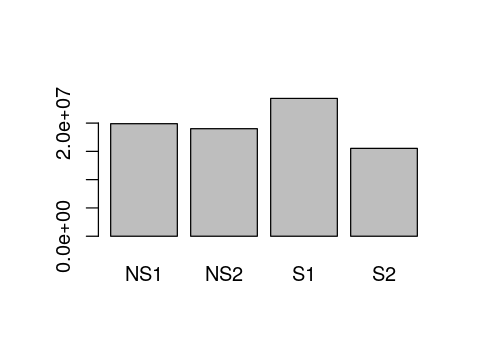

In [8]:
barplot(colSums(countData))

Define the experimental conditions - Note the order has to be the same as the column order of the `countData`:

Another remark is that it is important that the order of the levels is correct. In this case `NS` comes first, which means that we will be comparing $S \over NS$, so positive log fold change values are up in the stiumulated samples.

In [10]:
condition <- factor(c("NS", "NS", "S", "S"))
print(condition)

[1] NS NS S  S 
Levels: NS S


Prepare a dataframe with the names and conditions. This will be fed to `DESeq2`. Ensure that the order is unchanged!

In [11]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
NS1,NS
NS2,NS
S1,S
S2,S


Here we create a DESeq `DESeqDataSet` object for subsequent analysis:

In [12]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
#we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)

By printing `dds` to screen we can see some information

In [13]:
dds

class: DESeqDataSet 
dim: 41863 4 
metadata(1): version
assays(1): counts
rownames(41863): MIR1302-11 FAM138A ... AC007965.1 RNU6-1314P
rowData names(0):
colnames(4): NS1 NS2 S1 S2
colData names(2): sampleName condition

By comparing the `condition` factor in the `dds` object to the column names, you can confirm that the order is still correct

In [14]:
dds$condition

[1] NS NS S  S 
Levels: NS S

## Run the differential expression:

one function within `DESeq2` runs all steps required:

In [15]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## QC

DESeq2 estimates a factor to correct for the library size:

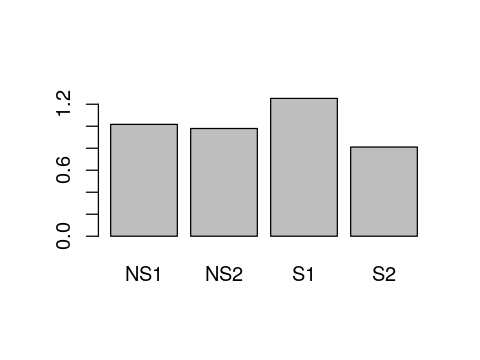

In [16]:
options(repr.plot.width=4, repr.plot.height=3)
barplot(sizeFactors(dds))

This is very comparable to the sum of all reads per sample of the raw data, however, `DESeq2` is less sensitive to outliers:

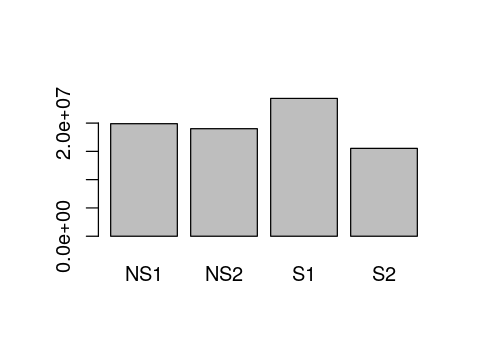

In [17]:
barplot(colSums(countData))

A scatter plot of sample vs sample will show us how the samples compare; are the replicates more similar than beween stimulated and non-stimulated?

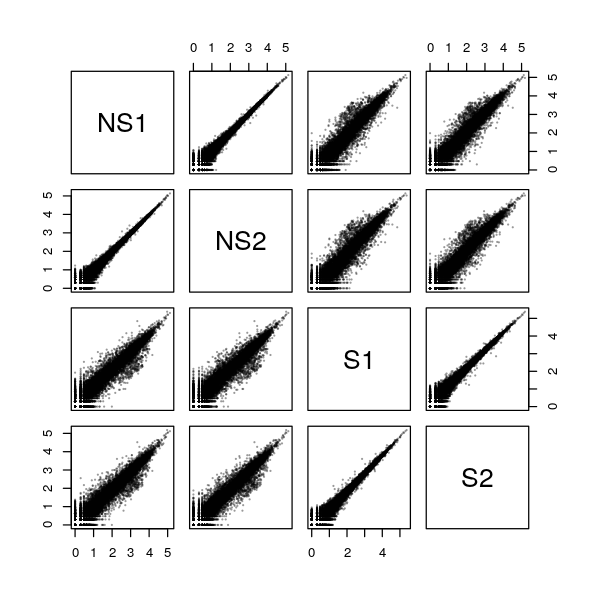

In [18]:
options(repr.plot.width=5, repr.plot.height=5)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

We can also do a PCA plot to understand inter-sample variation:

#### MA plot

An MA plot show the mean expression vs the log fold change and is a very common method to visualize the results of a differential expression plot. Significantly differentially expressed genes are colored red:

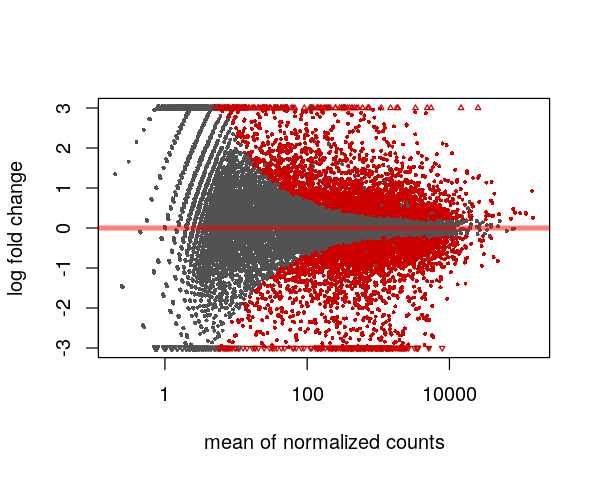

In [19]:
options(repr.plot.width=5, repr.plot.height=4)
plotMA(dds,ylim=c(-3,3))

### export the results

In [20]:
res <- results(dds)
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition S vs NS 
Wald test p-value: condition S vs NS 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
PLK1     2169.89887036599 -4.73276791052545  0.13660439511827 -34.6457953012998
CDKN1A   25241.2080295721   4.4868593631955 0.131313746953649   34.168999570009
CDC20    2087.37990872435 -4.46476556682858 0.132765443258258  -33.628973453157
TP53INP1 3332.81998084826  4.19869152304937 0.128439177176337  32.6901153943466
CCNA2    1833.68494342593 -4.66593933645505 0.145290280542013 -32.1146006398263
KIF20A   2304.20076082827 -4.67958381927593 0.146025361042091 -32.0463773270662
                        pvalue                  padj
                     <numeric>             <numeric>
PLK1     5.16814761362324e-263 8.15740419334293e-259
CDKN1A   6.98352056722933e-256 5.51139443165739e-252
CDC20    6.32881904304473e-248 

How many genes are differentially expressed?

In [21]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)

[1] 5612    6

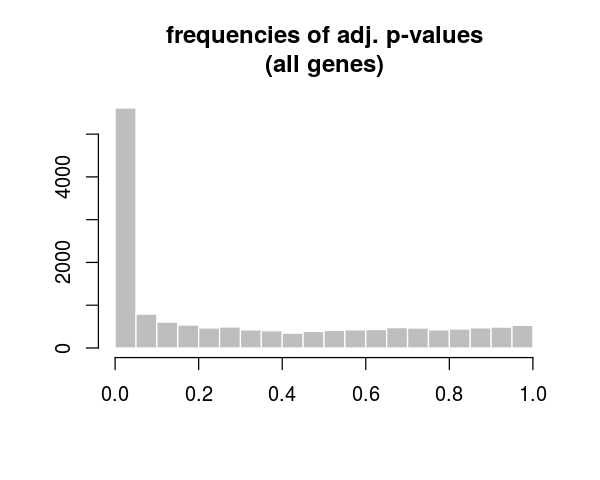

In [27]:
hist(res$padj, 
     col="grey", border="white", xlab="", ylab="", main="frequencies of adj. p-values\n(all genes)")


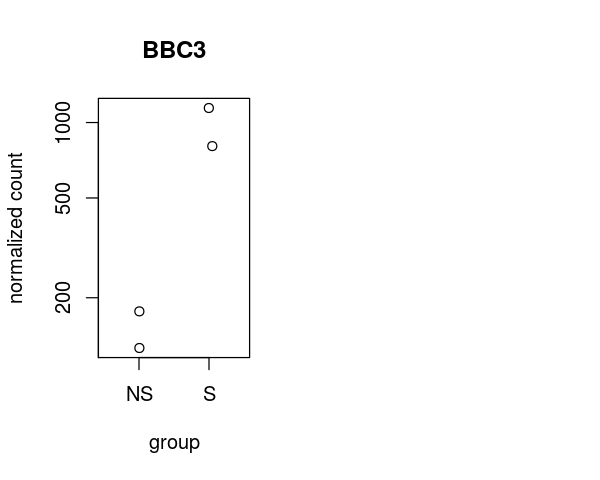

In [30]:
par(mfrow=c(1,2))
plotCounts(dds, gene="BBC3", normalized = TRUE)  


Save to disk:

In [22]:
write.table(res, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)

It is alwasy important to manually check a number of diff. expressing genes. As expected, `CDK1NA` goes up in the stimulated cells: 

In [23]:
res['BBC3',]

log2 fold change (MAP): condition S vs NS 
Wald test p-value: condition S vs NS 
DataFrame with 1 row and 6 columns
      baseMean log2FoldChange     lfcSE      stat       pvalue         padj
     <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
BBC3  562.3158       2.598969 0.2030378  12.80042 1.630715e-37 7.520835e-36

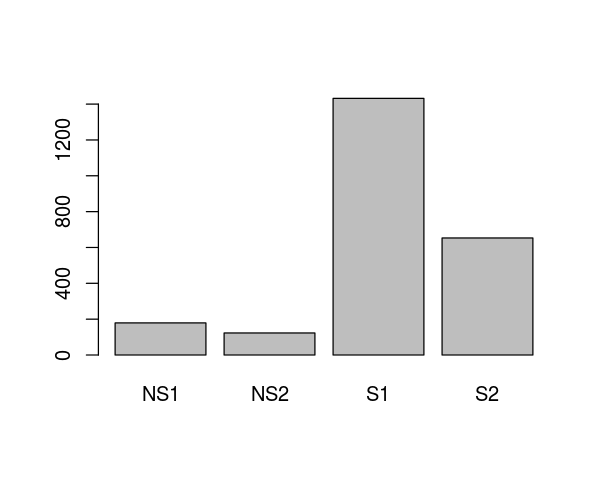

In [24]:
barplot(counts(dds)["BBC3",])

In [32]:
res.sorted <- res[order(res$padj),]
head(res.sorted)

log2 fold change (MAP): condition S vs NS 
Wald test p-value: condition S vs NS 
DataFrame with 6 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat        pvalue
         <numeric>      <numeric> <numeric> <numeric>     <numeric>
PLK1      2169.899      -4.662199 0.1336354 -34.88746 1.151771e-266
CDKN1A   25241.208       4.424579 0.1296332  34.13154 2.512584e-255
CDC20     2087.380      -4.401777 0.1301775 -33.81367 1.242057e-250
TP53INP1  3332.820       4.143085 0.1265154  32.74766 3.278210e-235
CCNA2     1833.685      -4.587429 0.1417288 -32.36766 7.829626e-230
KIF20A    2304.201      -4.599800 0.1426322 -32.24938 3.589351e-228
                  padj
             <numeric>
PLK1     1.683889e-262
CDKN1A   1.836699e-251
CDC20    6.052955e-247
TP53INP1 1.198186e-231
CCNA2    2.289383e-226
KIF20A   8.746052e-225

In [33]:
# identify genes with the desired adjusted p-value cut-off
DGEgenes <- rownames(subset(res.sorted, padj < 0.05))

# extract rlog-transformed values into a matrix
hm.mat_DGEgenes <- rlog.norm.counts[DGEgenes,]

library(pheatmap)
# heatmap of DEG sorted by p.adjust
pheatmap(hm.mat_DGEgenes, scale="none", show_rownames = FALSE, main = "DGE (no scaling)")
pheatmap(hm.mat_DGEgenes, scale="row", show_rownames = FALSE, main = "DGE (row-based z-score)")

ERROR: Error in eval(expr, envir, enclos): object 'rlog.norm.counts' not found
